### 데이터 전처리

In [1]:
from sklearn.linear_model import Ridge , LogisticRegression
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
import pandas as pd

mercari_df= pd.read_csv('mercari_train.tsv',sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


* train_id: 데이터 id
* name: 제품명
* item_condition_id: 판매자가 제공하는 제품 상태
* category_name: 카테고리 명
* brand_name: 브랜드 이름
* price: 제품 가격. 예측을 위한 타깃 속성
* shipping: 배송비 무료 여부. 1이면 무료(판매자가 지불), 0이면 유료(구매자 지불)
* item_description: 제품에 대한 설명

In [2]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


위 결과에서 메모리가 얼마 안든다고 생각할 수 있는데 피쳐벡터화 하면 엄청 많이 든다. 희소행렬로 한다고 해도 그렇다. dense로 하면 엄청 많이 든다. 
브랜드 네임이 price 에 꽤 중요한 영향을 끼친다고 생각하는데 null 값이 많다. 6만건 정도. 아쉽다.

item_description은 null이 4값 밖에 없지만 null 성 인 값이 많다. 뒤에서 설명함.

**타겟값의 분포도 확인**

희소행렬에서 첫번째로 확인해야 될 것. 타겟값이 정규분포를 형성하고 있는가. 그것을 확인해보자

C:\Users\esaw2\Anaconda3\envs\pygta5\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


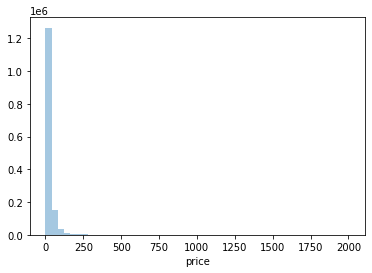

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.distplot(y_train_df,kde=False)

위 결과를 보면 당연히 정규분포는 어렵다. 고가 제품으로 갈수록 상품의 가지수가 그렇게 많지 않다.

**타겟값 로그 변환 후 분포도 확인**

그래서 늘 해왔던, 로그변환을 통해서 정규분포에 가깝게 바꿀 것임. 

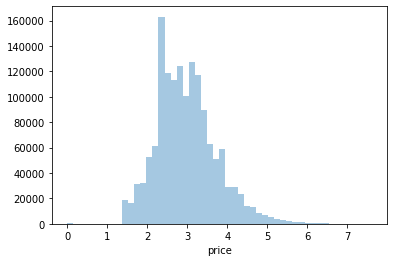

In [4]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.distplot(y_train_df,kde=False)


굉장히 깔끔하게 정규분포 형으로 만들어졌다. 이제 바꿔볼 것임

In [5]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

**각 피처들의 유형 살펴보기**

그냥 피쳐들이 어떤 형태로 되어있는지 분포도 정도 확인해 보는 것

In [6]:
print('Shipping 값 유형:\n',mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형:\n',mercari_df['item_condition_id'].value_counts())


Shipping 값 유형:
 0    819435
1    663100
Name: shipping, dtype: int64
item_condition_id 값 유형:
 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


특별한 건 없다

**불린 컨덱션으로 바꿈**

In [7]:
boolean_cond= mercari_df['item_description']=='No description yet'
mercari_df[boolean_cond]['item_description'].count()

82489

**category name이 대/중/소 와 같이 '/' 문자열 기반으로 되어 있음. 이를 개별 컬럼들로 재 생성**

In [8]:
# apply lambda에서 호출되는 대,중,소 분할 함수 생성, 대,중,소 값을 리스트 반환
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_Null' , 'Other_Null' , 'Other_Null']

# 위의 split_cat( )을 apply lambda에서 호출하여 대,중,소 컬럼을 mercari_df에 생성. 
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = \
                        zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 갯수만 추출
print('대분류 유형 :\n', mercari_df['cat_dae'].value_counts())
print('중분류 갯수 :', mercari_df['cat_jung'].nunique())
print('소분류 갯수 :', mercari_df['cat_so'].nunique())


대분류 유형 :
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64
중분류 갯수 : 114
소분류 갯수 : 871


혹시 위의 파이썬을 잘 모를 수 있어서 아래 코드로 설명해보면,

저렇게하면 리스트 형이 반환된다.

분할이 된 개별 원소들의 리스트가 반환이 된다.

그리고 zip(*←이렇게  아스태릭이있는데 , 파이썬에서 이건 튜플형으로 변환할거라고 명시하는 것이다)

왜냐면 우리가 원하는건 리스트가 아니라 각각의 개별 리스트가 cat_dae, cat_jung, cat_so로 가게하고 싶은것이다.


In [9]:
'test1/test2/test3'.split('/')

['test1', 'test2', 'test3']

나는 zip도 모르겠고 *도 모르겠다하면 아래처럼 간단하게 하면 됨.
함수는 똑같고 뭐만 달라지냐면 그대로 와서 별도의 category_list를 만들고 개별 칼럼들을 하나씩 할당하는 것임

In [10]:
# apply lambda에서 호출되는 대,중,소 분할 함수 생성, 대,중,소 값을 리스트 반환
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_Null' , 'Other_Null' , 'Other_Null']

# 위의 split_cat( )을 apply lambda에서 호출하여 대,중,소 컬럼을 mercari_df에 생성. 
mercari_df['category_list'] = mercari_df['category_name'].apply(lambda x : split_cat(x))
mercari_df['category_list'].head()

0                                [Men, Tops, T-shirts]
1    [Electronics, Computers & Tablets, Components ...
2                      [Women, Tops & Blouses, Blouse]
3               [Home, Home Décor, Home Décor Accents]
4                          [Women, Jewelry, Necklaces]
Name: category_list, dtype: object

이제 cat 대중소를 리스트에 추가하고 임의적으로 만들었던건 drop한다

In [11]:
mercari_df['cat_dae'] = mercari_df['category_list'].apply(lambda x:x[0])
mercari_df['cat_jung'] = mercari_df['category_list'].apply(lambda x:x[1])
mercari_df['cat_so'] = mercari_df['category_list'].apply(lambda x:x[2])

mercari_df.drop('category_list', axis=1, inplace=True) 

In [12]:
mercari_df[['cat_dae','cat_jung','cat_so']].head()

,cat_dae,cat_jung,cat_so
0,Men,Tops,T-shirts
1,Electronics,Computers & Tablets,Components & Parts
2,Women,Tops & Blouses,Blouse
3,Home,Home Décor,Home Décor Accents
4,Women,Jewelry,Necklaces


**Null값 일괄 처리**

브랜드 네임이 80몇만개가 null 인데 그냥 null 값 처리

나머지도 지장 없는 것들 null 값 처리

In [13]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

# 각 컬럼별로 Null값 건수 확인. 모두 0가 나와야 합니다.
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

In [14]:
mercari_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1482535 non-null  object 
 4   brand_name         1482535 non-null  object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482535 non-null  object 
 8   cat_dae            1482535 non-null  object 
 9   cat_jung           1482535 non-null  object 
 10  cat_so             1482535 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 124.4+ MB


name, brand_name, item_description 등등 object 성들이 있다.

인코딩 진행할 건데, 인코딩 하기 전에 brand name과 name 의 종류 확인

### 피처 인코딩과 피처 벡터화

**brand name과 name의 종류 확인**

In [15]:
print('brand name 의 유형 건수 :', mercari_df['brand_name'].nunique())
print('brand name sample 5건 : \n', mercari_df['brand_name'].value_counts()[:5])

brand name 의 유형 건수 : 4810
brand name sample 5건 : 
 Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


In [16]:
print('name 의 종류 갯수 :', mercari_df['name'].nunique())
print('name sample 7건 : \n', mercari_df['name'][:7])

name 의 종류 갯수 : 1225273
name sample 7건 : 
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


brand name 은 4810개. 유형 건수가 4810개니까 코드화하기엔 애매하다고 생각할 수 있다. 그런데 모양 자체가 워낙 크다. 워낙 희소행렬이다. 원핫 인코딩으로 만들어서 4810개를 추가해도 큰 문제가 안된다. 이걸 다 원핫인코딩해도 된다.

그런데 name은 좀 다르다. 종류 갯수를 보면 무려 122만건이다. 상품의 name이 굉장히 독특, 즉 상세하게 되어있다.

그리고 description을 보자.

**item_description의 문자열 개수 확인**

In [17]:
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 개수
print('item_description 평균 문자열 개수:',mercari_df['item_description'].str.len().mean())
#str은 스트링으로 바뀌는것. len 해서 평균 문자열 개수를 확인해볼 것임
mercari_df['item_description'][:2]

item_description 평균 문자열 개수: 145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

로컬에서 수행하건, colab에서 수행하건 gc를 한번 수행해주자.
garbage collector인데, 메모리 사용을 유심히보면서 해야 한다.

로컬에서 할 때는 작업관리자에서 메모리를 계속 봐주면 된다.

In [18]:
import gc
gc.collect()

0

이제부터 인코딩, 피처 벡터화 하고 인코딩 된 것들을 합쳐서 모델을 한번 선형 회귀, 회귀 트리를 적용해서 각각 비교해 볼 것이다.

**전 시간에 이어서**<br>

brand name은 4810개인데 원핫인코딩으로 인코딩 할 것이다.<br>
name과 item_description은 피처벡터화로 만들 거다.

**name은 Count로, item_description은 TF-IDF로 피처 벡터화**

name은 Countvectorize할 것임. 특별히 TF-IDF까지 할게 없다 저런 문장들은.

In [19]:
# name 속성에 대한 feature vectorization 변환
cnt_vec = CountVectorizer(max_features=30000)#max_features는 3만까지만할 것임.
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description 에 대한 feature vectorization 변환 
tfidf_descp = TfidfVectorizer(max_features = 50000, ngram_range= (1,3) , stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:',X_name.shape)
print('item_description vectorization shape:',X_descp.shape)


name vectorization shape: (1482535, 30000)
item_description vectorization shape: (1482535, 50000)


**사이킷런의 LabelBinarizer를 이용하여 원-핫 인코딩 변환 후 희소행렬 최적화 형태로 저장**

사이킷런에서는 label 인코딩을 먼저하고 원핫인코딩을 하는데,
LabelBinarizer를 하면 편리하게 원핫인코딩으로 반환 가능하고 옵션으로 sparse_output도 있어서 희소행렬 원핫인코딩으로도 변환이 된다.

In [20]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name= LabelBinarizer(sparse_output=True)#이걸 True로 하면 CSR 메트릭스 형태로 반환을 해준다.
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping= LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae= lb_cat_dae.fit_transform(mercari_df['cat_dae'])

lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])

lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [21]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand_shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
X_brand_shape:(1482535, 4810), X_item_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


위에 type을 확인하고 각각의 어레이에 대해서 shape를 확인해보면

csr.matrix 타입이다 각각이. shape은 당연히 브랜드는 4810개의 종류가 잇으니까 원핫인코딩을하면 그렇게 나오는거고 나머지는 그렇게 많지 않다.

이제 뭘할꺼냐면 카운트벡터화 한것, TFIDF 만든것, 원핫인코딩을 스파스 한 것을 각각을 더하고 최종데이터 셋을 만들거다.

In [22]:
import gc
gc.collect()

0

메모리 확인해보니까 가비지 안나옴.

**피처 벡터화된 희소 행렬과 원-핫 인코딩된 희소 행렬을 모두 scipy 패키지의 hstack()함수를 이용하여 결합**

In [23]:
from  scipy.sparse import hstack
import gc

# 앞에서 다 만들었던 csr matrix의 형태로 되어있는 희소행렬 객체 변수를 다 하나로 튜플형태로 만들어서 hstak의 인자로 넣는것임.
sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id,
            X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

#hstak은 수평성 방향으로 합쳐진다.스파스 행렬들을 hstak으로 합친다는 의미. 컬럼이 쭉 늘어나게 된다.

# 사이파이 sparse 모듈의 hstack 함수를 이용하여 앞에서 인코딩과 Vectorization을 수행한 데이터 셋을 모두 결합. 
X_features_sparse= hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)
#tocsr 하면 csr 메트릭스로 다시 변환 됨.


# 데이터 셋이 메모리를 많이 차지하므로 사용 용도가 끝났으면 바로 메모리에서 삭제. 
del X_features_sparse
gc.collect()


<class 'scipy.sparse.csr.csr_matrix'> (1482535, 85812)


0

85812개의 컬럼이 만들어졌다. 이제 데이터세트가 만들어진 것임. 이제 머신러닝 알고리즘 회귀모델을 선택을 해서 구축하고 평가를 해보자.

### 릿지 회귀 모델 구축 및 평가

**rmsle 정의**

y= 실제 값
y_pred = 예측 값
log1p를 해서 -를 한 값에 제곱(np.power (값, 2))에 평균mean을 하고 루트를 씌운다np.sqrt


evaluate_org_price는 RMSLE에 대해서 충실하게 하려고 만들엇다. 무슨 얘기냐면 price가 원본 값이 100이었으면

로그변환을 해서 그거보다 훨씬 작아진것임. 그래서 log100이 되었다. 원래값은 100이지만.

그렇기 때문에 예측값도 로그변환된 값이다. 예측값도 다시 원본으로 만들 필요가 있음.
exponential1을 쓴 이유가 그것임.

In [24]:
def rmsle(y , y_pred):
    # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산 
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test , preds): 
    
    # 원본 데이터는 log1p로 변환되었으므로 exmpm1으로 원복 필요. 
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)
    
    # rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

**여러 모델에 대한 학습/예측을 수행하기 위해 별도의 함수인 model_train_predict()생성.** 

해당 함수는 여러 희소 행렬을 hstack()으로 결합한 뒤 학습과 테스트 데이터 세트로 분할 후 모델 학습 및 예측을 수행 

In [25]:
import gc 
from  scipy.sparse import hstack

def model_train_predict(model,matrix_list):
    # scipy.sparse 모듈의 hstack 을 이용하여 sparse matrix 결합
    X= hstack(matrix_list).tocsr()     
    
    X_train, X_test, y_train, y_test=train_test_split(X, mercari_df['price'], 
                                                      test_size=0.2, random_state=156)
    
    # 모델 학습 및 예측
    model.fit(X_train , y_train)
    preds = model.predict(X_test)
    
    del X , X_train , X_test , y_train 
    gc.collect()
    
    return preds , y_test

릿지부터 테스트해보자.

**릿지 선형 회귀로 학습/예측/평가. Item Description 피처의 영향도를 알아보기 위한 테스트 함께 수행**

item description이라던가 name이라던가 text 값을 피쳐벡터화 했는데, 이런 의문이 들수 있다.

item description이 상품 예측을 하는데 얼마나 도움이 될까? 하는.

그래서 item description을 제외했을때랑 포함했을때의 비교를 할 거다.

In [26]:
linear_model = Ridge(solver = "lsqr", fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model ,matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test , linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model , matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:',  evaluate_org_price(y_test ,linear_preds))


Item Description을 제외했을 때 rmsle 값: 0.5027988032523101
Item Description을 포함한 rmsle 값: 0.4711428795206281


포함하니까 확실히 좋아졌다.

In [27]:
import gc
gc.collect()

0

### LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가

In [28]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds , y_test = model_train_predict(model = lgbm_model , matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:',  evaluate_org_price(y_test , lgbm_preds))

LightGBM rmsle 값: 0.4573055090383379


릿지보다 조금 더 좋게 나왔다. colab에선 30분 정도 걸림

주의해야될건 메모리를 계속 봐야함. 7. 몇기가 정도 된다. 

개인 pc가 8기가 정도 되도 죽을 수도 있다. 기존에 띄워놨던 다른 프로그램 다 죽여야함.

In [29]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:',  evaluate_org_price(y_test , preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값: 0.4508937689565401


LGBM 결과에 0.45 곱하고 릿지를 구한걸 0.55 해서 결과를 섞을거임. 회귀는 이게 가능하다. 대신 합쳐서 1이 되어야함.

예측값이 가령 100 , 101 이 나온다면  100 * 0.45 + 101 * 0.55 를 할 수 있다.

결과는 아주 약간 줄었다.

메루카리는 아주 흥미로운 경연대회였음. 관심있으면 조금 더 드라이브해보면

백오브워드로 픽쳐 벡터라이즈화 해서 하는게 맞느냐, 임베딩형식으로 워드투 벡이나 이런걸 적용해서 텍스트 파일을 그런쪽으로 하느냐 그런게 있을 수 있다.

워드 배치라는 워드 클래스 모델도 여기에서 상당히 소개가 됐었다.전반적으로는 희소벡터, 희소행렬에서 머신러닝 알고리즘이 어떻게

최적화 될 수 있는지등에 대한 다양한 솔루션들이 메루카리에 소개되어있으니까 직접 보고 실력향상의 기회가 될 수 있다.